# Aprendizado Profundo por Reforço para Detecção de Respostas Cerebrais a Estímulo Auditivo
*Aluno: [Alexandre Gomes Caldeira](https://orcid.org/0000-0002-4851-3417); Orientador: [Leonardo Bonato Felix](https://orcid.org/0000-0002-6184-2354)*.

**Disponível em [github.com/Alexandre-Caldeira/drl-ord/blob/main/DRL_ORD.ipynb](https://github.com/Alexandre-Caldeira/drl-ord/blob/main/DRL_ORD.ipynb), e [pitch no Google Drive](link) <sup>1,2</sup>.**

Artigos produzidos com os resultados discutidos aqui:
1. [Patient-adaptive Objective Response Detection using Reinforcement Learning <br> (Aceito para publicação, CBEB 2024)](https://drive.google.com/file/d/191mQeyK0PxDVYrpS6Daull_epmzeavzT/view?usp=sharing)

2. [Evaluating Deep Reinforcement Learning on Auditory Steady State Response Detection <br> (Em submissão para publicação)](https://drive.google.com/file/d/1ykkx8_rxxhN6wHBJBFsyJ2YF8ANYEkGY/view?usp=sharing)

Respositórios com código:

**Artigo 1: [Alexandre-Caldeira/CBEB24-RL-ORD](https://github.com/Alexandre-Caldeira/CBEB24-RL-ORD)**

**Artigo 2: [Alexandre-Caldeira/drl-ord](https://github.com/Alexandre-Caldeira/drl-ord)**


**<sup>1</sup>** *Aqui é apresentado um overview resumido do problema e dados, da arquitetura, treino e validação dos modelos, mas o notebook com treino completo e resultados extendidos pode ser acessado em [comparing_3_models.ipynb](https://github.com/Alexandre-Caldeira/drl-ord/blob/main/epd-kit/draft_notebooks/comparing_3_models.ipynb) (tempo de execução de aprox. 48hrs).*

**<sup>2</sup>** *Para replicar o ambiente exato de execução desse notebook, siga os passos descritos no tutorial em [arch.md](https://github.com/Alexandre-Caldeira/drl-ord/blob/main/arch.md).*


In [1]:
# Carrega bibliotecas necessárias

## Manipulação de dados
import pickle
import numpy as np
import pandas as pd

## Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

## Aprendizado de máquina
import torch as th
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN, A2C
from sklearn.model_selection import train_test_split

# O problema e os dados

Se oferecido estímulo sonoro a seres humanos, é possível detectar respostas elétricas medidas no escalpo quando não há perda auditiva. Porém, eletroencefalograma não-invasivo é extremamente ruidoso. 

![](https://github.com/Alexandre-Caldeira/CBEB24-RL-ORD/blob/main/paper_figures/eeg_simulation_frequency.png?raw=true)

Nesse trabalho, simulamos respostas auditivas em estado permanente (ASSRs) a diferentes níveis de relação sinal-ruído (SNR), para ajustarmos detectores e aplicarmos em dados experimentais com voluntários de audição normal.

## Carga e visualização dos dados

In [2]:
# Carrega e apresenta exemplo de dados sintéticos em diferentes SNR
## Método de simulação disponível em ./matlab_sim_sourcecode



# A arquitetura e método de solução

Seguindo resultados a nível do estado da arte utilizando [Q-Learning tabular](https://github.com/Alexandre-Caldeira/CBEB24-RL-ORD), propomos comparar detectores clássicos com métodos de Aprendizado Profundo por Reforço.

<br>

**Agente:** deve comparar medidas na frequência observada com referências, e decidir há resposta;

**Abordagens:** Deep Q-Networks **(DQN)**, Advantage Actor Critic **(A2C)** e Proximal Policy Optimization **(PPO)**;
 - *Arquitetura e implementação conforme publicada, disponível na biblioteca [stable-baselines3](https://github.com/DLR-RM/stable-baselines3/)*.

**Ações:** detectar (1) ou não (0) uma resposta;

**Estado:** medidas de resposta objetiva para 1 frequência de decisão e 3 frequências de referência;

**Recompensas:** uma imediata **(Ra)**, e outra ao fim da janela de decisão **(Rb)**;
- **(Ra)** Verdadeiro Positivo (TP), Verdadeiro Negativo (TN), Falso Positivo (FP) ou Falso Negativo (FN);
- **(Rb)** $\Big[\frac{(1-\alpha)^2}{100} - \frac{\alpha^2}{100} \Big] + \Big[\frac{TP^2}{100} -\frac{FP^2}{100} \Big]$; $\alpha$ sendo FP desejado para o exame.

## Definindo ambientes

### Treino e Teste

Em teste, não há acesso ao Verdadeiro Positivo na recompensa imediata **(Ra)**.

In [3]:
class FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes = data.shape[0]-1
        self.frequencies = data.shape[1]-1
        self.measures = data.shape[2]
        self.windows = data.shape[3]-1
        self.current_episode = 0
        self.current_window = 2 # Discards first 2 seconds of experiments
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.fp_des = 0.05
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    
    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode=='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode

        focus_measure = self.data[self.current_episode, frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.arange(9, 17)
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[self.current_episode, nf, :, window] for nf in noise_frequencies]
         
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()

        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]
        
        if episode != -1:
            self.current_episode = episode

        reward = 0

        # Frequencies above index 8 are noise only (but agent doesn't know)
        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        ### Instant reward (Ra)
        tp = 0; fp = 0; fn =0; tn = 0
        if action == 1:
            if should_detect:
                tp = 0
            else:
                fp = 1
        else:
            if should_detect:
                fn = 0
            else:
                tn = 1

        reward = tp-fp-fn+tn

        
        window_done = self.current_frequency >= self.frequencies
        episode_terminated = self.current_window >= self.windows
        self.current_frequency += 1
        info = {'tp_rate':np.nan,'fp_rate':np.nan}

        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)
            
            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)
                
            reward = +( -(((100-self.fp_des)**2)/100 +(self.fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )/100
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(episode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if episode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            ### Long term reward (Rb)
            reward = +( -(((100-self.fp_des)**2)/100+(self.fp_des**2)/-100)
                    +((np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))/100
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        return self.state, reward, episode_terminated, truncated, info
    

In [4]:
class TEST_FrequencyDetectionEnv(FrequencyDetectionEnv):
    def __init__(self, data):
        super(TEST_FrequencyDetectionEnv, self).__init__(data)

    def step(self, action, episode = -1):

        if episode != -1:
            self.current_episode = episode

        reward = 0

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        episode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}

        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(episode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if episode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2)}
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

        tp = 0; fp = 0; fn =0; tn = 0
        if action == 1:
            if should_detect:
                tp = 0
            else:
                fp = 1
        else:
            if should_detect:
                fn = 0
            else:
                tn = 1

        reward = tp-fp-fn+tn

        return self.state, reward, episode_terminated, False, info

### Fine-tuning e validação
Em validação, há somente recompensa imediata **(Ra)** e também não há acesso ao Verdadeiro Positivo.

In [5]:
class EVAL_FINETUNE_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(EVAL_FINETUNE_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes =  data.shape[2]-1
        self.frequencies = data.shape[0]-1
        self.measures = data.shape[1]
        self.windows = data.shape[2]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[nf, :, window] for nf in noise_frequencies]
         
        # measures = my_norm(np.concatenate(([focus_measure], noise_measures), axis=0).flatten())
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
            
            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +((np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2), 
                    'tp_hist:':self.tpr_hist,'fp_hist:':self.fpr_hist}
            
            # print(info)
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 1
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 1
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        # reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

In [6]:
class EVAL_EXP_FrequencyDetectionEnv(gym.Env):
    """Custom Environment for Frequency Objective Response Detection that follows gymnasium interface"""

    def __init__(self, data):
        super(EVAL_EXP_FrequencyDetectionEnv, self).__init__()

        self.data = data
        self.episodes =  data.shape[2]-1
        self.frequencies = data.shape[0]-1
        self.measures = data.shape[1]
        self.windows = data.shape[2]-1
        self.current_episode = 0
        self.current_window = 2
        self.current_frequency = 0

        # Action space: 0 (no detection) or 1 (detection)
        self.action_space = spaces.Discrete(2)

        # Observation space: 5 measures for each of the 4 frequencies (1 focus + 3 noise)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4*self.measures,), dtype=np.float32)

        # Initialize the internal state
        self.state = None
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0   
        self.tpr_hist = []
        self.fpr_hist = []  
        self.latest_result = {'tp_rate':np.nan,'fp_rate':np.nan}   

    def reset(self, seed=None, options=None):
        """Resets the environment to an initial state and returns the initial observation."""
        super().reset(seed=seed)
        
        if  self.current_episode< self.episodes:
            self.current_episode +=1
        else:
            self.current_episode = np.random.randint(0, self.episodes)

        self.current_window = 2
        self.current_frequency = 0
        self.false_positives = 0
        self.true_positives = 0
        self.fp_rate = 0
        self.tp_rate = 0        
         
        self.tpr_hist = []
        self.fpr_hist = []
        
        # Initialize the state
        self.state = self._get_state(self.current_frequency, self.current_window)
        return self.state, self.latest_result

    def _get_state(self, frequency, window, episode= 0):
        """Helper function to get the state at a given frequency and window."""
         
        if episode != 0:
            self.current_episode = episode
         
        # print(frequency)
        focus_measure = self.data[frequency, :, window]
        
        # Select 3 random noise frequencies, excluding the current focus frequency
        noise_indices = np.setdiff1d(np.arange(9, 17), frequency - 9 if frequency >= 9 else [])
        noise_frequencies = np.random.choice(noise_indices, 3, replace=False)
        noise_measures = [self.data[nf, :, window] for nf in noise_frequencies]
         
        # measures = my_norm(np.concatenate(([focus_measure], noise_measures), axis=0).flatten())
        measures = np.concatenate(([focus_measure], noise_measures), axis=0).flatten()
       
        return np.array(measures, dtype=np.float32)

    def step(self, action, episode = -1):
        """Executes one time step within the environment."""
        # Returns:
        # tuple (observation, reward, terminated, truncated, info).
        # Return type:
        # Tuple[Tuple | Dict[str, Any] | ndarray | int, float, bool, bool, Dict]

        if episode != -1:
            self.current_episode = episode

        reward = 0
        fp_des = 0.05

        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect:
                self.true_positives += 1
            else:
                self.false_positives += 1

        self.current_frequency += 1
        window_done = self.current_frequency >= self.frequencies
        epsiode_terminated = self.current_window >= self.windows
        info = {'tp_rate':np.nan,'fp_rate':np.nan}
        if window_done:
            self.state = self._get_state(self.current_frequency-1, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn


            self.tp_rate = 100*self.true_positives / (self.frequencies//2+1)
            self.fp_rate = 100*self.false_positives / (self.frequencies//2+1)

            reward = +( -(((100-fp_des)**2)/100 +(fp_des**2)/-100) +((self.fp_rate)**2)/(-100)+ ((self.tp_rate)**2)/(100) )
            
            self.tpr_hist.append(self.tp_rate)
            self.fpr_hist.append(self.fp_rate)

            if not(epsiode_terminated):
                self.current_window += 1
                self.current_frequency = 0
                self.true_positives = 0
                self.false_positives = 0
                    
        if epsiode_terminated:
            self.state = self._get_state(self.current_frequency, self.current_window)

            self.tp_rate = 100*self.true_positives / (self.current_frequency+1)
            self.fp_rate = 100*self.false_positives / (self.current_frequency+1)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn
            
            reward = +( -(((100-fp_des)**2)/100+(fp_des**2)/-100)
                    +((np.round(np.mean(self.fpr_hist),4))**2)/(-100)
                    +((np.round(np.mean(self.tpr_hist),4))**2)/(100))
           
            truncated = False

            info = {'tp_rate':np.round(np.mean(self.tpr_hist),2),'fp_rate':np.round(np.mean(self.fpr_hist),2), 
                    'tp_hist:':self.tpr_hist,'fp_hist:':self.fpr_hist}
            
            # print(info)
            self.latest_result = info

            self.tpr_hist = []
            self.fpr_hist = [] 
            self.current_window = 2
            self.current_frequency = 0
            self.true_positives = 0
            self.false_positives = 0

        else:
            self.state = self._get_state(self.current_frequency, self.current_window)

            should_detect = self.current_frequency <= 8
            tp = 0; fp = 0; fn =0; tn = 0
            if action == 1:
                if should_detect:
                    tp = 0
                else:
                    fp = 1
            else:
                if should_detect:
                    fn = 0
                else:
                    tn = 1

            reward = tp-fp-fn+tn

            truncated = False

        # reward = tp-fp-fn+tn

        return self.state, reward, epsiode_terminated, truncated, info

    def render(self, mode='human'):
        """Render the environment for visualization purposes."""
        if mode =='human':
            print(f'Window: {self.current_window}, Frequency: {self.current_frequency},TP: {self.tp_rate}, FP: {self.fp_rate}')

    def close(self):
        """Clean up any resources used by the environment."""
        pass

# Resultados e próximos passos

Etapas:
1. **Pré-treino** com dados sintéticos para aprendizado de representação profunda a diferentes níveis de ruído.

2. **Teste** em diversos níveis de ruído (incluindo ainda não vistos), comparando com detectores clássicos.

3. **Validação cruzada** com dados experimentais utilizando 1 exemplo de exame como treino e 10 exames como teste.

## Modelo demonstrativo

### Pré-treinamento

In [7]:
# Train DQN model
with open('./epd-kit/database/c_states_dict_acer_v3.pkl', 'rb') as f:
    c_states_big = pickle.load(f)

data = c_states_big[10]
timesteps = (118)*(16)*10

env = FrequencyDetectionEnv(data)
model_dqn = DQN('MlpPolicy', env, verbose=1#, learning_rate=5*1e-4,gamma=0.9,
            #exploration_fraction= 0.1, exploration_initial_eps = 1, exploration_final_eps = 0.05
            ,policy_kwargs=dict(activation_fn=th.nn.ReLU,net_arch=[data.shape[2]+1])
                )
model_dqn.learn(total_timesteps=timesteps)
model_dqn.save('./epd-kit/models/minimal_dqn_snr10.zip')
_, latest = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75e+03 |
|    ep_rew_mean      | 678      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 962      |
|    time_elapsed     | 7        |
|    total_timesteps  | 6988     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 1721     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75e+03 |
|    ep_rew_mean      | 914      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 956      |
|    time_elapsed     | 14       |
|    total_timesteps  | 13976    |
| train/              |        

In [8]:
latest

{'tp_rate': 94.04,
 'fp_rate': 4.81,
 'episode': {'r': 1233.883103, 'l': 1747, 't': 20.472935},
 'TimeLimit.truncated': False,
 'terminal_observation': array([-5.4701287e-03, -9.8068779e-03, -1.2500367e-02,  1.0000000e+02,
        -8.6516571e+00,  1.7828535e+02, -2.4882750e-01, -2.8058376e+00,
        -2.3309395e-01, -2.8732316e+00,  1.0000000e+02,  8.0946045e+00,
         1.2101654e+01, -1.2238027e+00, -1.2152891e+00, -2.6336387e-01,
        -1.3511403e+00,  1.0000000e+02,  1.0487729e+01,  2.1909281e+01,
        -2.1998508e+00, -1.6989717e+00, -2.6683033e-01, -1.6874896e+00,
         1.0000000e+02,  8.4888134e+00,  3.6419060e+01, -1.9353815e+00],
       dtype=float32)}

### Teste

In [9]:
def my_evaluate_model(model, env, num_episodes=50):
    tpr_hist = []
    fpr_hist = []
    rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        obs = obs[0]
        done = False
        total_reward = 0
        tpr_episode = []
        fpr_episode = []

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if not np.isnan(info['tp_rate']):
                tpr_episode.append(info['tp_rate'])
                fpr_episode.append(info['fp_rate'])

                done = True

        tpr_hist.append(np.mean(tpr_episode))
        fpr_hist.append(np.mean(fpr_episode))
        rewards.append(total_reward)

    return tpr_hist, fpr_hist, rewards

In [10]:
snr = 5
data = c_states_big[snr]

test_env = TEST_FrequencyDetectionEnv(data)
model_dqn = DQN.load('./epd-kit/models/minimal_dqn_snr10.zip', env = test_env)

# Avalia performance atual do modelo
tpr_dqn, fpr_dqn, rewards_dqn = my_evaluate_model(model_dqn, test_env,num_episodes=10)
pd.DataFrame({'TPR':tpr_dqn, 'FPR':fpr_dqn,'REW':rewards_dqn}).mean()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TPR     62.085
FPR      1.271
REW    753.800
dtype: float64

### Validação cruzada

In [11]:
# Cross-validation a 30 dB (3 mins)
# Function to fine-tune the model
def fine_tune_model(model_class, pretrained_model_path, save_model_path, data, reset_model):
    env = EVAL_FINETUNE_FrequencyDetectionEnv(data)
    
    if reset_model == True:  # On first run, initialize model as copy of pretrained
        model = model_class.load(pretrained_model_path, env=env)
    else:
        model = model_class.load(save_model_path, env=env)

    model.learn((data.shape[2] - 1) * (data.shape[0] - 1))
    model.save(save_model_path)
    return model

# Function to validate the model
def validate_model(model_class, save_model_path, data, hist_tpr, hist_fpr):
    env = EVAL_EXP_FrequencyDetectionEnv(data)
    obs, info = env.reset()

    model = model_class.load(save_model_path, env=env)

    for test_episode in range((data.shape[2] - 1) * (data.shape[0] - 1)):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated:
            obs, info = env.reset()
            hist_tpr.append(info['tp_rate'])
            hist_fpr.append(info['fp_rate'])
            env.close()

    return hist_tpr,hist_fpr

# Function to run cross-validation
def cross_validate_model(model_class, pretrained_model_path, save_model_path, k_folds=5):

    # cv_results = {fold: {iint: {}} for iint in range(1, 12) for fold in range(1, k_folds+1)}
    cv_results = {}
    for fold in range(1, 6):
        cv_results[fold] = {iint:{} for iint in range(1,6)}
    cv_results_preview = {'tpr':[],'fpr':[]}
    intensidades = ['70', '60', '50', '40', '30']

    # For each fold
    for fold in range(1, k_folds+1):

        # For every intensity
        for iint in range(5, 6):
            print(f'Intensidade: {intensidades[iint-1]} dB')
            hist_tpr = []
            hist_fpr = []

            ### Take one random voluntary as fine-tuning instance, and 10 others as validation
            train_index, test_index = train_test_split(np.arange(1,12), train_size=1)

            # Fine-tune once
            for ivol in train_index:
                data = c_states_exp_filt[ivol, iint]
                fine_tune_model(model_class, pretrained_model_path, save_model_path, data, 
                                reset_model = True # resets model at start of each intensity
                                )

            # Test in 10 other voluntaries
            for ivol in test_index:
                    data = c_states_exp_filt[ivol, iint]
                    validate_model(model_class, save_model_path, data, hist_tpr, hist_fpr)

            cv_results[fold][iint]['tpr'] = hist_tpr
            cv_results[fold][iint]['fpr'] = hist_fpr

        cv_results_preview['tpr'].append(np.mean(hist_tpr))
        cv_results_preview['fpr'].append(np.mean(hist_fpr))

    mtpr = np.mean(cv_results_preview['tpr'])
    stpr = np.std(cv_results_preview['tpr']) 
    mfpr = np.mean(cv_results_preview['fpr'])
    sfpr = np.std(cv_results_preview['fpr']) 
    print(f'Final TPR: { mtpr } +/- { stpr }')
    print(f'Final FPR: { mfpr } +/- { sfpr }')

    return cv_results, cv_results_preview

# Load data
with open('./epd-kit/database/c_states_dict_exp_filt.pkl', 'rb') as f:
    c_states_exp_filt = pickle.load(f)

# Fine-tune and validate models
cv_dqn, cvp_dqn = cross_validate_model(DQN, './epd-kit/models/minimal_dqn_snr10.zip', './epd-kit/models/cv-exp-minimal_dqn_snr10.zip',5)

Intensidade: 30 dB
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Intensidade: 30 dB
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrap

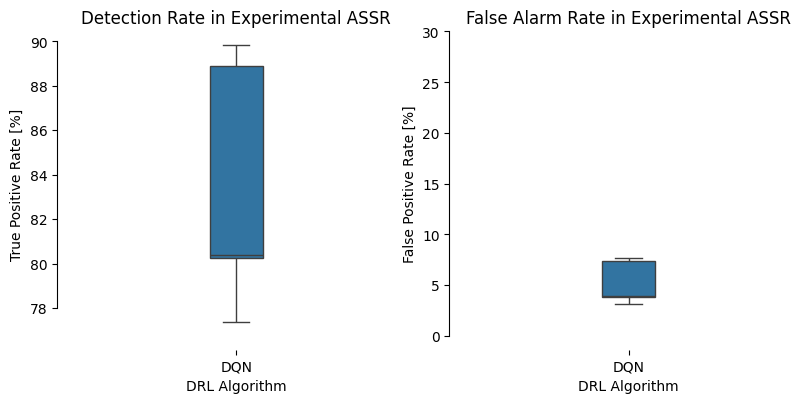

In [35]:
# Mostra resultados experimentais
def get_fold_metrics(cv_dict,intensity, metric, prev = False):
    collected_metric = []
    for fold in cv_dict.keys():
        if not(prev):
            for intensity in np.arange(1,6):
                for val in cv_dict[fold][intensity][metric]:
                    collected_metric.append(val)
        else:
            for val in cv_dict[fold][1][metric]:
                collected_metric.append(val)

    return collected_metric

inten = 4
tpr = pd.DataFrame({'DQN':cvp_dqn['tpr']})

fpr = pd.DataFrame({'DQN':cvp_dqn['fpr']})

plt.figure(figsize=(8,4))
plt.subplot(121)
sns.boxplot(tpr,gap=.8)
plt.title('Detection Rate in Experimental ASSR')
plt.ylabel('True Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.tight_layout()

plt.subplot(122)
sns.boxplot(fpr, gap=.8)
plt.title('False Alarm Rate in Experimental ASSR')
plt.ylabel('False Positive Rate [%]')
plt.xlabel('DRL Algorithm')
plt.ylim([0,30])
plt.tight_layout()
sns.despine(offset=10, trim=True)
plt.show()

## Modelo completo

### Pré-treinamento

### Teste

### Validação cruzada